In [1]:
import pickle
import mlflow
import os
import pandas as pd
import tqdm as tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utilities import load_checkpoint
from utils.metrics import IntegratedEvaluator
import pyarrow.parquet as pq
from omegaconf import OmegaConf
from datasets.dataOps import create_ood_datasets, create_loc_ood_datasets, create_dataloaders
from hydra.utils import instantiate

In [2]:
# A miscellaneous function to generate test results report
def generate_txt_report(output_path: str,
                        exp_name: str,
                        ml_flow_run_name: str,
                        summary: dict,
                        per_variable_table: pd.DataFrame,
                        last_timestep_table: pd.DataFrame,
                        physical_metrics: dict
                        ):

    with open(output_path, "w", encoding="utf-8") as f:
        # Header
        f.write("=" * 50 + "\n")
        f.write("RESULTS REPORT\n")
        f.write("=" * 50 + "\n\n")

        f.write(f"Experiment: {exp_name}\n")
        f.write(f"MLflow Run: {ml_flow_run_name}\n\n")

        # Summary
        f.write("-" * 50 + "\n")
        f.write("SUMMARY\n")
        f.write("-" * 50 + "\n")
        for name, metric in summary.items():
            f.write(f"{name}: {metric}\n")
        f.write("\n")

        # Physical Metrics
        f.write("-" * 50 + "\n")
        f.write("PHYSICAL METRICS\n")
        f.write("-" * 50 + "\n")
        for name, metric in physical_metrics.items():
            f.write(f"{name}: {metric}\n")
        f.write("\n")

        # Tables
        f.write("-" * 50 + "\n")
        f.write("TABLE: Per variable entire table\n")
        f.write("-" * 50 + "\n")
        f.write(per_variable_table.to_string(index=True))
        f.write("\n\n")

        f.write("-" * 50 + "\n")
        f.write("TABLE: Last time step\n")
        f.write("-" * 50 + "\n")
        f.write(last_timestep_table.to_string(index=True))
        f.write("\n\n")

        # Tail
        f.write("=" * 50 + "\n")
        f.write("END OF REPORT\n")
        f.write("=" * 50 + "\n")

In [3]:
# A dictionary useful to for aesthehics in the report (row names)
corr_variables = {"Var_0" : "DVS",
                  "Var_1" : "LAI",
                  "Var_2" : "TAGP",
                  "Var_3" : "TWSO",
                  "Var_4" : "TWLV",
                  "Var_5" : "TWST",
                  "Var_6" : "TWRT",
                  "Var_7" : "DMI",
                  "Var_8" : "ASRC",
                  "Var_9" : "GASS",
                  "Var_10": "MRES"
                 }

In [4]:
RUN_ID = "7f59d35f6e96477e9a5491c8ac131e15" # Put here your running id for the target experiment

In [5]:
mlflow.set_tracking_uri("file:./mlruns")
client = mlflow.client.MlflowClient()

/home/agudeloacosta/miniconda3/envs/pg_seq2seq/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:184: FutureWarning: The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.
  return FileStore(store_uri, store_uri)


In [6]:
dico = client.get_run(RUN_ID).to_dictionary()
print(dico["data"]["tags"]["exp_name"])

010_FSL


In [7]:
os.listdir(dico["info"]["artifact_uri"].removeprefix("file://"))

['best_model', 'config_exp.yaml', 'checkpoints']

In [8]:
dico["info"]["artifact_uri"]

'file:///home/agudeloacosta/HOMEdev/pg-sequence_learning/mlruns/866452063275857873/7f59d35f6e96477e9a5491c8ac131e15/artifacts'

In [9]:
cfg = OmegaConf.load(os.path.join(dico["info"]["artifact_uri"].removeprefix("file://"), "config_exp.yaml"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)

data = {}
for array in ["static_data", "before_ts", "after_ts", "target_ts", "mask_target", "cat_dicos"]:
    with open(f"{cfg.raw_data_folder + array}.pkl", "rb") as f:
        data[array] = pickle.load(f)
table = pq.read_table(cfg.raw_data_folder + cfg.info_ts_file)
ids = table.to_pandas().index.to_list()
list_unic_cat = [len(dico.keys()) for dico in data["cat_dicos"].values()]

train_dataset, val_dataset, test_dataset, ood_dataset = create_loc_ood_datasets(ids=ids,
                                                            static_data=data["static_data"],
                                                            before_ts=data["before_ts"],
                                                            after_ts=data["after_ts"],
                                                            target_ts=data["target_ts"],
                                                            mask_target=data["mask_target"],
                                                            train_size=cfg.training.train_size,
                                                            val_size=cfg.training.val_size,
                                                            raw_data_folder=cfg.raw_data_folder,
                                                            means_and_stds_path=cfg.means_and_stds_path,
                                                           )

_, test_loader, ood_loader = create_dataloaders(train_dataset,
                                                test_dataset,
                                                ood_dataset,
                                                batch_size=cfg.training.batch_size)

encoder = instantiate(cfg.model.encoder,
                        list_unic_cat=list_unic_cat).to(device)
decoder = instantiate(cfg.model.decoder).to(device)

optimizer = instantiate(cfg.training.optimizer,
                        params = list(encoder.parameters()) + list(decoder.parameters()))

Using device: cuda

          Train_DS = 142876 obs
          Val_DS = 17859 obs
          Test_DS = 17860 obs
          OOD_Test_DS = 21491 obs
          


In [10]:
with open("data/work_data/means_and_stds.pkl", "rb") as f:
    means_and_stds = pickle.load(f)

In [11]:
# checkpoint = torch.load("checkpoints/10_entire_physical_HardWiredBIG_60_eps/best_model.pth")
checkpoint = torch.load(dico["info"]["artifact_uri"].removeprefix("file://") + "/best_model/best_model.pth")

load_checkpoint(checkpoint,
                encoder,
                decoder,
                optimizer)

=== Loading checkpoint ===


In [12]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_hat_mask = []
    batch_target = []
    batch_mask = []
    ids = []
    for batch in test_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        before_ts = batch["before_ts"].to(device)
        after_ts = batch["after_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        mask_target = batch["mask_target"].to(device)

        latent, x_t = encoder(static_data_num, static_data_cat, before_ts)
        h_t = latent
        generated_ts = [] 
        for t in range(after_ts.shape[1]):
            output, h_t, h_output = decoder(x_t.unsqueeze(1),
                                            h_t,
                                            after_ts[:, t, :],
                                            ar=True)
            generated_ts.append(output)
            x_t = output
            
        batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_mask.append(mask_target)

/tmp/ipykernel_1314671/2175679806.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
/tmp/ipykernel_1314671/2175679806.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])


In [13]:
print(batch_target[0].shape, batch_hat_target[0].shape)

torch.Size([20, 200, 11]) torch.Size([20, 200, 11])


In [14]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")
concat_real_mask = torch.cat(batch_mask, dim=0).to("cpu")

In [15]:
# find the maximum value index

cosa = abs((concat_batch_hat_target*concat_real_mask)-(concat_batch_target*concat_real_mask))

x_flat = cosa.view(-1)

# Get index of max value
max_index = x_flat.argmax()

# Convert flat index back to multi-dimensional index
max_position = torch.unravel_index(max_index, cosa.shape)

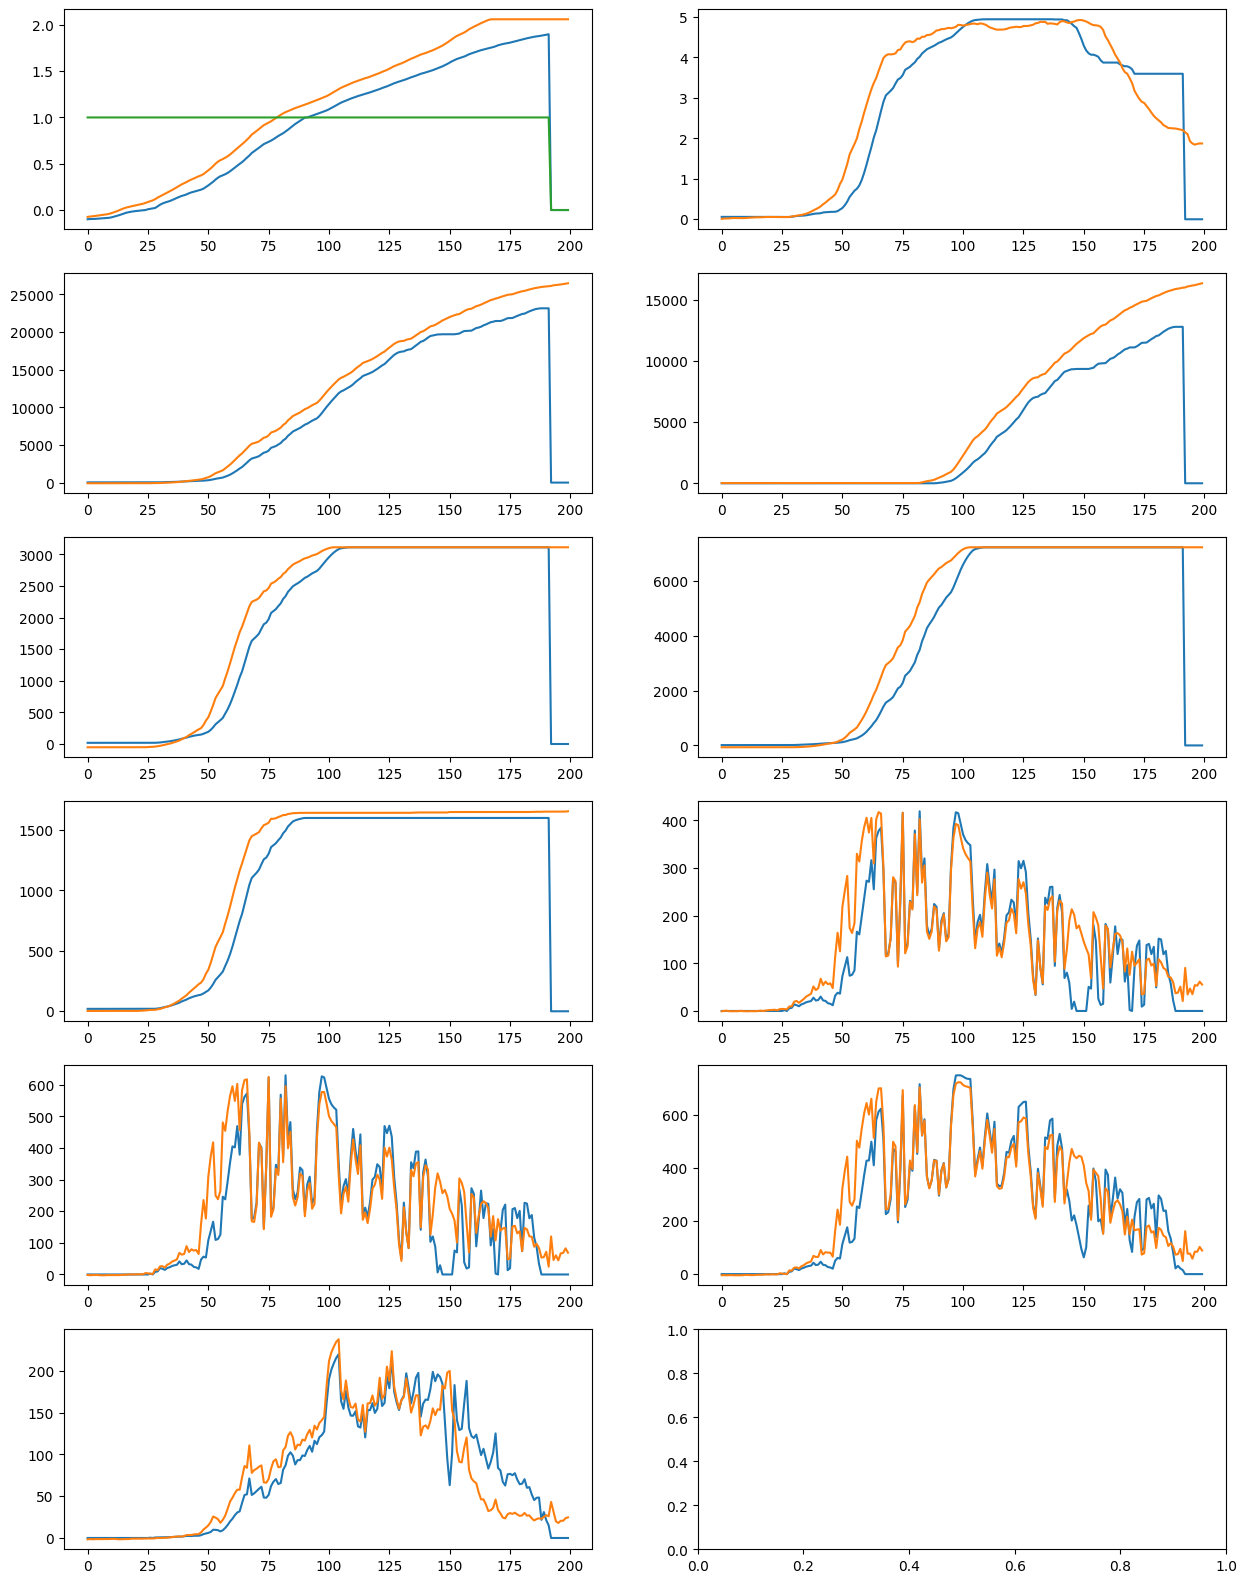

In [16]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
i = 21
sns.lineplot(concat_batch_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_hat_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_real_mask[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_hat_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_hat_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_hat_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_hat_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_hat_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_hat_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_hat_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_hat_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_hat_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
sns.lineplot(concat_batch_hat_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
plt.show()

In [17]:
evaluator = IntegratedEvaluator(y_true=concat_batch_target.numpy(),
                                y_pred=concat_batch_hat_target.numpy(),
                                mask=concat_real_mask.squeeze(-1).numpy()
                                )

In [18]:
y_true=concat_batch_target.numpy()
y_pred=concat_batch_hat_target.numpy()
mask=concat_real_mask.squeeze(-1).numpy()

In [19]:
per_var_table = evaluator.to_dataframe()
per_var_table.index = per_var_table.index.to_series().map(corr_variables)

physical_metrics = {"V_biom" : evaluator._biomass_violation([2, 3, 4, 5]).item(),
                    "V_ass" : evaluator._assimilation_violation([8, 9, 10]).item(),
                    "V_mat" : evaluator._dry_matter_increase_violation([2, 6, 7]).item()
                    }

last_ts_table = evaluator.evaluate_last_timestep()
last_ts_table.index = last_ts_table.index.to_series().map(corr_variables)

In [20]:
os.makedirs(name="results_reports/", exist_ok=True)
generate_txt_report(output_path= "results_reports/" + \
                    dico["data"]["tags"]["exp_name"].split("_")[0] + "_" \
                    + RUN_ID + "_test_results_report.txt",
                    exp_name=dico["data"]["tags"]["exp_name"],
                    ml_flow_run_name=RUN_ID,
                    summary=evaluator.summary(),
                    per_variable_table=per_var_table,
                    last_timestep_table=last_ts_table,
                    physical_metrics=physical_metrics
                    )

# OOD Results

In [ ]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_hat_mask = []
    batch_target = []
    batch_mask = []
    ids = []
    for batch in ood_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        before_ts = batch["before_ts"].to(device)
        after_ts = batch["after_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        mask_target = batch["mask_target"].to(device)

        latent, x_t = encoder(static_data_num, static_data_cat, before_ts)
        h_t = latent
        generated_ts = [] 
        for t in range(after_ts.shape[1]):
            output, h_t, h_output = decoder(x_t.unsqueeze(1),
                                            h_t,
                                            after_ts[:, t, :],
                                            ar=True)
            generated_ts.append(output)
            x_t = output
            
        batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_mask.append(mask_target)

/tmp/ipykernel_1314671/1109843951.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
/tmp/ipykernel_1314671/1109843951.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])


In [ ]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")
concat_real_mask = torch.cat(batch_mask, dim=0).to("cpu")

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
i = 6
sns.lineplot(concat_batch_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_hat_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_real_mask[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_hat_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_hat_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_hat_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_hat_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_hat_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_hat_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_hat_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_hat_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_hat_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
sns.lineplot(concat_batch_hat_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
plt.show()

In [ ]:
evaluator = IntegratedEvaluator(y_true=concat_batch_target.numpy(),
                                y_pred=concat_batch_hat_target.numpy(),
                                mask=concat_real_mask.squeeze(-1).numpy()
                                )

In [ ]:
per_var_table = evaluator.to_dataframe()
per_var_table.index = per_var_table.index.to_series().map(corr_variables)

physical_metrics = {"V_biom" : evaluator._biomass_violation([2, 3, 4, 5]).item(),
                    "V_ass" : evaluator._assimilation_violation([8, 9, 10]).item(),
                    "V_mat" : evaluator._dry_matter_increase_violation([2, 6, 7]).item()
                    }

last_ts_table = evaluator.evaluate_last_timestep()
last_ts_table.index = last_ts_table.index.to_series().map(corr_variables)

In [ ]:
generate_txt_report(output_path= "results_reports/" + dico["data"]["tags"]["exp_name"].split("_")[0] + "_" +RUN_ID + "_OOD_results_report.txt",
                    exp_name=dico["data"]["tags"]["exp_name"],
                    ml_flow_run_name=RUN_ID,
                    summary=evaluator.summary(),
                    per_variable_table=per_var_table,
                    last_timestep_table=last_ts_table,
                    physical_metrics=physical_metrics
                    )